# Embeddings from EfficientNet

In [ ]:
# https://www.kaggle.com/code/micajoumathematics/fine-tuning-efficientnetb0-on-cifar-100

In [ ]:
# import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

!pip install -U efficientnet &> /dev/n_ull

In [ ]:
# load data
(X, y), (X_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 4s 0us/step


In [ ]:
# parameters for data
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100
batch_size =64

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# build efficientnet architecture
import efficientnet.keras as efn 

efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = 100, input_shape = input_shape)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

# load pretrained weights
model.load_weights('/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project/best_weight.h5')

model.summary()

16804768/16804768 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
__________________________________________

In [ ]:
# function for resizing images
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

In [ ]:
# datagen for efficientnet
class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            

train_generator = DataGenerator(X, y, shuffle = False)
valid_generator = DataGenerator(X_test, y_test,shuffle=False)

In [ ]:
# build encoder model from efficientnet
from keras import models
newModel = models.Model(inputs =  model.inputs, outputs = model.layers[1].output)

In [ ]:
# extract embeddings from train set
res =newModel.predict(train_generator)
# add index to train  embedding
index = np.zeros((res.shape[0],1))
for i in range(index.shape[0]):
  index[i,0] = i+1
res1 = np.hstack([index,res])

print(res1.shape)

781/781 [==============================] - 98s 125ms/step
(49984, 1281)


In [ ]:
# extract embeddings from test set
res2 =newModel.predict(valid_generator)
# add index to train  embedding
index = np.zeros((res2.shape[0],1))
for i in range(index.shape[0]):
  index[i,0] = i+1
res3 = np.hstack([index,res2])
print(res3.shape)

156/156 [==============================] - 26s 168ms/step
(9984, 1281)


In [ ]:
# save embeddings
np.savetxt('train_embeddings.csv',res1,delimiter=',')
np.savetxt('test_embeddings.csv',res3,delimiter=',')

In [ ]:
# save train images
from  tqdm import tqdm
!mkdir train_images
for i in tqdm(range(res.shape[0]),'saving images'):
  plt.imsave('train_images/image'+str(i+1)+'.png',X[i])

# compress images
!zip -r 'train_images.zip' 'train_images' &> /dev/null

saving images: 100%|██████████| 49984/49984 [00:29<00:00, 1715.71it/s]


In [ ]:
# save test images
!mkdir test_images
for i in tqdm(range(res2.shape[0]),'saving images'):
  plt.imsave('test_images/image'+str(i+1)+'.png',X_test[i])

# compress images
!zip -r 'test_images.zip' 'test_images' &> /dev/null

saving images: 100%|██████████| 9984/9984 [00:06<00:00, 1539.58it/s]


In [ ]:
# perform clustering on train embeddings
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100, random_state=0, n_init="auto",).fit(res)
train_cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [ ]:
# get cluster labels for test embeddings
test_cluster_labels = kmeans.predict(res2)

In [ ]:
#save train set clustering labels
np.savetxt('train_labels.csv',train_cluster_labels,delimiter=',',fmt='%d')
# save train set clustering cluster centers
np.savetxt('train_cluster_centers.csv',cluster_centers,delimiter=',') 
# save test set clustering labels
np.savetxt('test_labels.csv',test_cluster_labels,delimiter=',',fmt='%d')


In [ ]:
# move to drive

!cp 'train_embeddings.csv' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project'
!cp 'test_embeddings.csv' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project'

!cp 'train_images.zip' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project'
!cp 'test_images.zip' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project'

!cp 'train_labels.csv' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project'
!cp 'test_labels.csv' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project'

!cp 'train_cluster_centers.csv' '/gdrive/MyDrive/Colab Notebooks/Information Retrieval CSE508/Project'


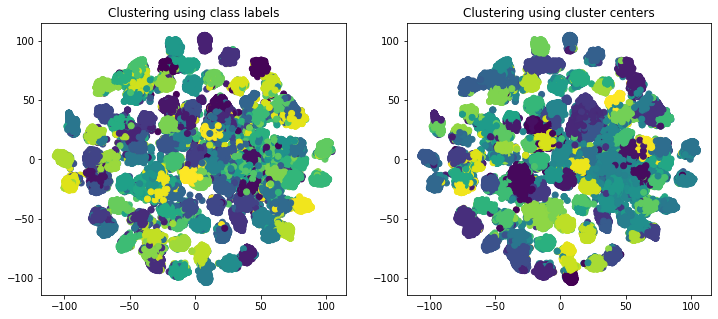

In [ ]:
# visualize embeddings in 2D space using class labels and clustering labels
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
tsne = TSNE(n_components = 2,n_jobs=-1)
train_tsne_data = tsne.fit_transform(pca.fit_transform(res))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(train_tsne_data[:,0], train_tsne_data[:,1],c=list(y[:train_tsne_data.shape[0]]))
plt.title('Clustering using class labels')
plt.subplot(1,2,2)
plt.scatter(train_tsne_data[:,0], train_tsne_data[:,1],c=train_cluster_labels)
plt.title('Clustering using cluster labels')
plt.show()

In [ ]:
# unmount drive
drive.flush_and_unmount()

# Embeddings from Autoencoders - Not working till now

In [ ]:
# autoencoder part
autoencoder = models.load_model('autoencoder_cifar100_final.h5')

In [ ]:
res1 = autoencoder(X[:10]/255)

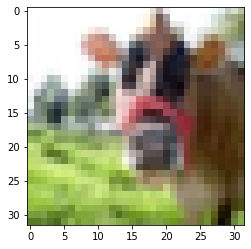

In [ ]:
plt.imshow(X[0])

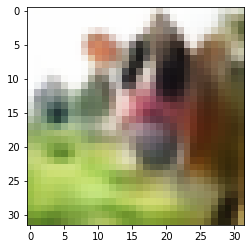

In [ ]:
plt.imshow(res1[0])

In [ ]:
encoder = models.Model(inputs =  autoencoder.inputs, outputs = autoencoder.layers[9].output)
decoder = models.Model(inputs =  autoencoder.layers[10].input, outputs = autoencoder.outputs)

In [ ]:
res1 = encoder.predict(X/255)
res2 = res1.reshape(-1,512)
res3 = res2.reshape(-1,8,8,8)
res4 = decoder.predict(res3)

1563/1563 [==============================] - 4s 3ms/step


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
tsne = TSNE(n_components = 2,n_jobs=-1)
train_tsne_data = tsne.fit_transform(pca.fit_transform(res2))

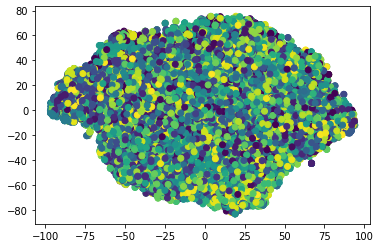

In [ ]:
plt.scatter(train_tsne_data[:,0], train_tsne_data[:,1],c=list(y))